fovs 30


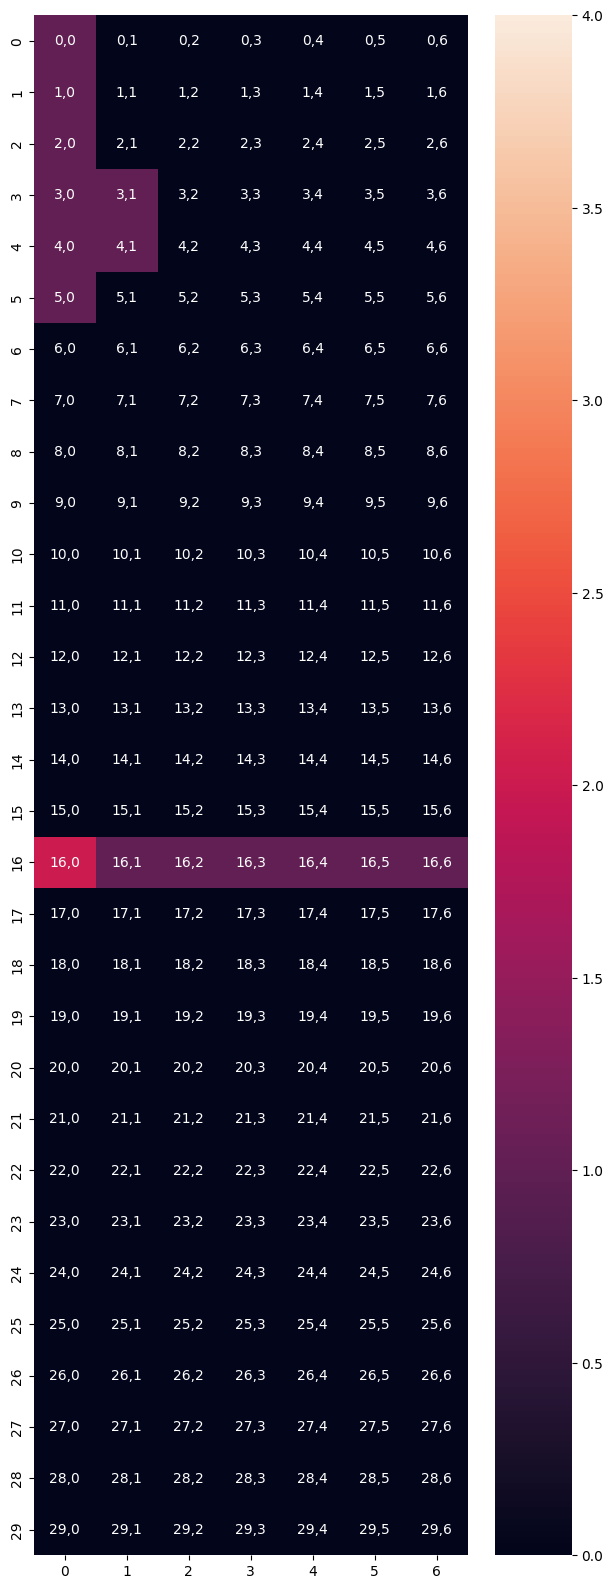

1: 405 done, 2: all channels done, 3:puncta extracted 4:channel consolidated


In [1]:
from exm.exseq.args import Args
from exm.exseq.exseq import ExSeq
args = Args(
    mov_path = '/mp/nas3/ruihan/20221218_zebrafish/code{}/Channel{} SD_Seq000{}.nd2',
    layout_file = '/mp/nas3/ruihan/20221218_zebrafish/code0/out.csv',
    out_path = '/mp/nas3/ruihan/20221218_zebrafish/',
    sheet_path = '/mp/nas2/ruihan/ExM-Toolbox/ruihan_september/gene_list.numbers',
    codes = [0,1,2,3,4,5,6],
    ref_code = 0,
    mapping = False,
    fovs = None)
exseq = ExSeq(args)
exseq.visualize_progress()